# Masking tissue region in whole slide images
<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/develop/examples/example_tissuemask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/develop/examples/example_tissuemask.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/></a>

_Please note that if you are selecting Kaggle badge, in the Kaggle notebook you have to login and enable the internet connection from the setting panel on the right in order to install tiatoolbox from the internet._

## About this notebook
This  jupyter notebook can be run on any computer with a standard browser and no programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on the badge "Open in Colab" above. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on either Github or colab, so you cannot inadvertently mess it up, and you should feel free to experiment. Use the notebook's File Menu if you wish to save your own (changed) notebook.

Before running the notebook outside Colab, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/develop/README.md#install-python-package) file.

## Welcome to Tiatoolbox
In this example, we will show how you can use tiatoolbox to easily detect the tissue region in whole slide images. Apart from tissue regions, WSIs usually show large blank (glass) background areas that contain no information. Therefore, it is essential to detect the informative (tissue) region in the WSI before any action (like patch extraction and classification). We call this step, "tissue masking". In particular, here we will introduce the use of our module
`tissuemask` ([details](https://github.com/TIA-Lab/tiatoolbox/blob/develop/tiatoolbox/tools/tissuemask.py)) which identifies the tissue region using an automatic image thresholding algorithm ([Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method)) and some morphological operations. 

### First cell in bash
This cell prepares the Colab environment for the use of `tiatoolbox`. This cell produces no output if it has been run before in the same Colab session.

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools
!pip install git+git://github.com/TIA-Lab/tiatoolbox@develop

## Importing related libraries
We will start by importing some libraries required to run this notebook.

In [24]:
from tiatoolbox.wsicore import wsireader
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, a WSI for our experiment. Downloading is needed once in each Colab session. Downloaded data by the notebook is stored under `Files` directory which is accessible via the 📁 in the left menu.

In [53]:
!wget http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs

--2021-05-06 15:23:53--  http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs
Resolving openslide.cs.cmu.edu (openslide.cs.cmu.edu)... 128.2.209.93
Connecting to openslide.cs.cmu.edu (openslide.cs.cmu.edu)|128.2.209.93|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1938955 (1.8M) [image/tiff]
Saving to: ‘CMU-1-Small-Region.svs’

CMU-1-Small-Region. 100%[===================>]   1.85M  2.16MB/s    in 0.9s    

2021-05-06 15:23:54 (2.16 MB/s) - ‘CMU-1-Small-Region.svs’ saved [1938955/1938955]



# Reading a WSI and its Thumbnail
Our code shields the user from the incompatible formats produced by different models of scanners from different vendors. The function `wsireader.get_wsireader` has as input a particular WSI, with a particular image format, and outputs an object `wsi_reader`, whose base class is WSIreader, and whose derived class depends on the image format. For more information about WSI reading in tiatoolbox, please refer to the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader) and the [notebook example](https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/example_wsiread.ipynb) dedicated to this topic.

In [54]:
wsi_reader = wsireader.get_wsireader(
                input_img='CMU-1-Small-Region.svs')
print(type(wsi_reader))

<class 'tiatoolbox.wsicore.wsireader.OpenSlideWSIReader'>


First, let's check the basic WSI information, such as magnification, dimension, etc. (mpp= microns per pixel).

In [55]:
wsi_info = wsi_reader.info.as_dict()
# Print one item per line
print(*list(wsi_info.items()), sep='\n')

('objective_power', 20.0)
('slide_dimensions', (2220, 2967))
('level_count', 1)
('level_dimensions', ((2220, 2967),))
('level_downsamples', [1.0])
('vendor', 'aperio')
('mpp', (0.499, 0.499))
('file_path', PosixPath('CMU-1-Small-Region.svs'))


Working with `tiatoolbox`, it is easy to load a WSI thumbnail using the `slide_thumbnail` method of the `wsi_reader` object. The thumbnail can be loaded with different resolution units. Following options are available for the `units` argument:

- `mpp`: microns per pixel
- `power`: objective power of the scanner
- `level`: the level in the WSI pyramidal file
- `baseline`: pixels per baseline pixel

We will load (and show) the thumbnail at x1.25 objective power as follows:

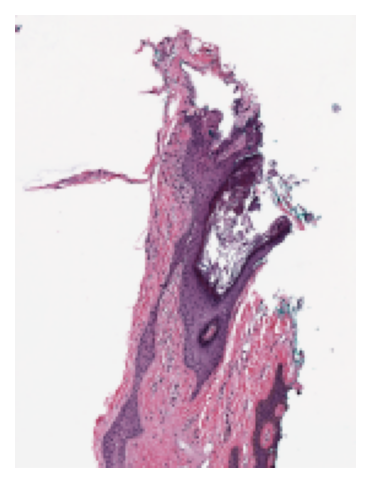

In [59]:
wsi_thumb = wsi_reader.slide_thumbnail(resolution=1.25, units='power')
plt.imshow(wsi_thumb)
plt.axis('off')
plt.show()

# Generating tissue mask in 2 lines of code
The task is to distinguish between tissue and glass (no tissue) in the WSI. We compute a mask, by which we mean a binary colouring of the pixels to either black=glass or white=tissue. In order to do that, we utilize the functionalities in the `tissuemask` tool of the tiatoolbox. In particular, `MorphologicalMasker` is used to generate the tissue mask which uses the WSI thumbnail (`wsi_thumb`) because it is more efficient to work with the much smaller low resolution thumbnail.

Here, we instantiate a `MorphologicalMasker` object and use it to extract the mask of `wsi_thumb`:

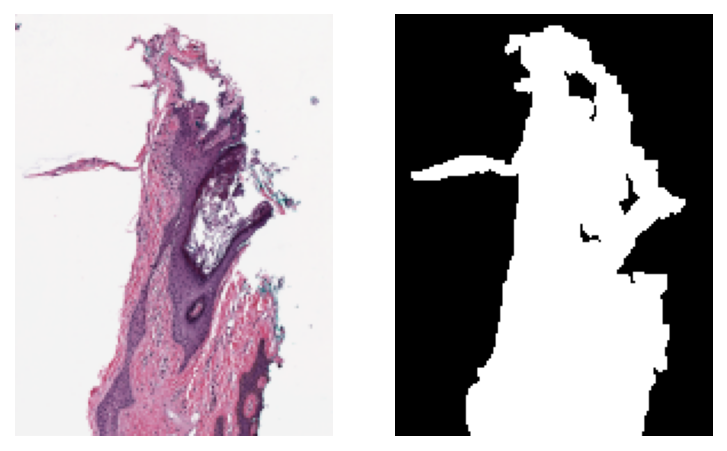

In [60]:
from tiatoolbox.tools.tissuemask import MorphologicalMasker

masker = MorphologicalMasker(power=1.25)  # The first line!
masks = masker.fit_transform([wsi_thumb]) # The second line!

# showing the result
plt.subplot(1,2,1)
plt.imshow(wsi_thumb)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(masks[0], cmap='gray')
plt.axis('off')
plt.show()

`MorphologicalMasker` can be used with different __optional__ arguments: 

- `kernel_size`: Size of the elliptical kernel to be used for morphological operations in mask post-processing.
- `mpp`: The microns per pixel of the image to be masked. Used to calculate `kernel_size`.
- `power`: The objective power of the image to be masked. Used to calculate `kernel_size`.
- `min_region_size `: Minimum region size in pixels to consider as foreground.

_Please note_ that only one of the `kernel_size`, `mpp`, or `power` argument should be used because only the `kernel_size` is important and used in morphological operations whereas the latter two are used to calculate a suitable `kernel_size`, if not given (the default `kernel_size=1` is used if no argument is given on object instantiating).
More information can be found on [tissuemask](https://github.com/TIA-Lab/tiatoolbox/blob/develop/tiatoolbox/tools/tissuemask.py) definition. 

In this example, we specified `power=1.25` because earlier we used the same magnification power to load `wsi_thumb`.

Let's investigate the effect of changing the parameters of `MorphologicalMasker`:

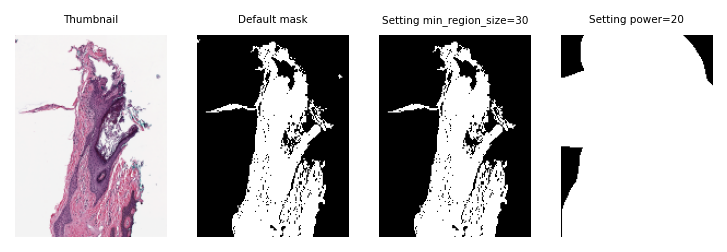

In [64]:
def make_subplot(img, title, k):
    plt.subplot(1,4,k)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title, fontdict={'fontsize': 5})

# default: kernel_size=1, min_region_size=1
masker = MorphologicalMasker() 
masks_default = masker.fit_transform([wsi_thumb])

# kernel_size=1, min_region_size=30
# meaning deleting objects smaller than 30 pixels in area
masker = MorphologicalMasker(min_region_size=30) 
masks_small = masker.fit_transform([wsi_thumb])

# power=20
# resulting to a over estimated kernel_size, hence bigger mask
masker = MorphologicalMasker(power=20) 
masks_big = masker.fit_transform([wsi_thumb])

# showing the result
make_subplot(wsi_thumb, 'Thumbnail', 1)
make_subplot(masks_default[0], 'Default mask', 2)
make_subplot(masks_small[0], 'Setting min_region_size=30', 3)
make_subplot(masks_big[0], 'Setting power=20', 4)

plt.show()

You may have noticed that in `fit_trainsform` function we put the input into brackets, i.e. `masker.fit_transform([wsi_thumb])`. This is because the `fit_transform` function supports batch processing of the input thumbnils. In other words, it accepts a list of RGB images or a numpy array in the expected shape of NxHxWxC (number images, height, width, channels), then the function would output a list of generated tissue masks.